In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess
import csv

In [128]:
def is_power_of_two(n):
  return (n & (n - 1) == 0) and n != 0


def generate_cache_accesses(cache_line_size,
                            num_cache_lines=512,
                            num_operations=100):
  import random
  base_addresses = [i * cache_line_size for i in range(num_cache_lines)]
  data_values = [
      "0x11111111",
      "0x22222222",
      "0x33333333",
      "0x44444444",
      "0x55555555",
      "0x66666666",
      "0x77777777",
      "0x88888888",
      "0x99999999",
      "0x12345678",
      "0x79824691",
      "0x16420982",
      "0x15946378",
      "0x687b890a",
      "0xf809b234",
  ]

  accesses = []
  for _ in range(num_operations):
    base = random.choice(base_addresses)
    offset = random.randint(0, cache_line_size - 1)  # Offset within cache line
    address = base + offset
    if random.choice([True, False]):
      accesses.append(["R", f"0x{address:08X}", ""])
    else:
      data = random.choice(data_values)
      accesses.append(["W", f"0x{address:08X}", data])

  return accesses

def save_accesses_to_csv(cache_line_size):
  accesses = generate_cache_accesses(cache_line_size)

  file_path = f"cache_accesses_{cache_line_size}.csv"

  with open(file_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Operation", "Address", "Data"])
    writer.writerows(accesses)

  print(f"Generated cache accesses and saved to {file_path}")

In [129]:
cache_line_sizes = [8,16,32, 64, 128]
l1_cache_lines = [16, 32, 64]
l2_cache_lines = [64, 128, 256]
column_names = ['cycles', 'misses', 'hits', 'primitiveGateCount']


def run_c_program(cache_line_size, l1_cache_lines, l2_cache_lines):
  command = [
      "./project", "-c", "10000000", "--cacheline-size",
      str(cache_line_size), "--l1-lines",
      str(l1_cache_lines), "--l2-lines",
      str(l2_cache_lines), "--l1-latency", "4", "--l2-latency", "16",
      "--memory-latency", "50", "--tf=tracefile", f"cache_accesses_{cache_line_size}.csv"
  ]

  result = subprocess.run(command, capture_output=True, text=True)
  if result.returncode != 0:
    print(f"Error running C program: {result.stderr}")

In [130]:
def read_results_from_csv(filename):
  if os.path.exists(filename):
    return pd.read_csv(filename, names=column_names, header=None)
  else:
    print(f"File {filename} not found.")
    return pd.DataFrame()

In [131]:
for size in cache_line_sizes:
    save_accesses_to_csv(size)

Generated cache accesses and saved to cache_accesses_8.csv
Generated cache accesses and saved to cache_accesses_16.csv
Generated cache accesses and saved to cache_accesses_32.csv
Generated cache accesses and saved to cache_accesses_64.csv
Generated cache accesses and saved to cache_accesses_128.csv


In [132]:
results_df = pd.DataFrame()

In [145]:
for cache_line_size in cache_line_sizes:
  for l1_lines in l1_cache_lines:
    for l2_lines in l2_cache_lines:
      for i in range(3):
        run_c_program(cache_line_size, l1_lines, l2_lines)

        filename = 'results.csv'
        df = read_results_from_csv(filename)
        df['cache_line_size'] = cache_line_size
        df['l1_cache_lines'] = l1_lines
        df['l2_cache_lines'] = l2_lines
        results_df = pd.concat([results_df, df], ignore_index=True)


    cycles misses hits primitiveGateCount  cache_line_size  l1_cache_lines  \
0    18676    233   10              13375                8              16   
1    18676    233   10              13375                8              16   
2    18676    233   10              13375                8              16   
3    18676    233   10              13375                8              16   
4    18676    233   10              13375                8              16   
..     ...    ...  ...                ...              ...             ...   
373  18132    224   13              23067                8              64   
374  18132    224   13              23067                8              64   
375  17832    221   16              33947                8              64   
376  17832    221   16              33947                8              64   
377  17832    221   16              33947                8              64   

     l2_cache_lines  
0                64  
1                64

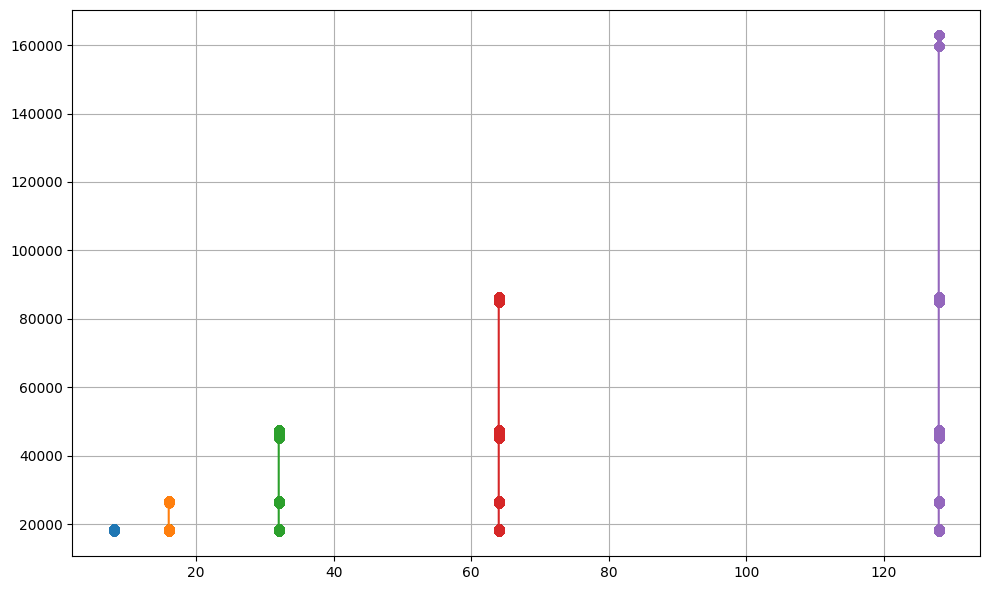

In [146]:
plt.figure(figsize=(10, 6))

for cls in cache_line_sizes:
  subset = results_df[results_df['cache_line_size'] == cls]
  print(subset)
  plt.plot(subset['cache_line_size'],
           subset['cycles'],
           label=f'Cache Line Size {cls}',
           marker='o',
           linestyle='-')

plt.xlabel("Cache Line Size")
plt.ylabel("Cycles")
plt.grid(True)
plt.tight_layout()
plt.show()